In [1]:
import os
import shutil
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio
from tensorflow.keras import models, Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import *
from sklearn.model_selection import train_test_split
import tensorflow_addons as tfa
from tensorflow.keras import backend as K

In [2]:
seed = 69
tf.random.set_seed(seed)
np.random.seed(seed)
sample_rate = 16000

data_dir = 'data/combined_normalized'
classes = np.array(os.listdir(data_dir))
num_classes = len(classes)

classes_index = {label: index for index, label in enumerate(classes)}
print('Classes:', classes_index)

filenames = tf.io.gfile.glob(data_dir + '/*/*')
labels = [classes_index[f.split(os.path.sep)[-2]] for f in filenames]
num_samples = len(filenames)
print('Number of total examples:', num_samples)

x_train, x_val, y_train, y_val = train_test_split(filenames, labels, test_size=0.2, random_state=seed, shuffle=True, stratify=labels)

print('Train:', len(x_train))
print(collections.Counter(y_train))
print('Val:', len(x_val))
print(collections.Counter(y_val))

Classes: {'angry': 0, 'fear': 1, 'happy': 2, 'neutral': 3, 'sad': 4}
Number of total examples: 9531
Train: 7624
Counter({0: 1603, 2: 1559, 1: 1557, 4: 1552, 3: 1353})
Val: 1907
Counter({0: 401, 2: 390, 1: 389, 4: 388, 3: 339})


(376, 128, 1)


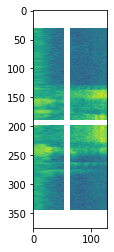

In [26]:
wav = tf.io.read_file(x_train[0])
wav, sr = tf.audio.decode_wav(wav, desired_channels=1)
wav = tf.squeeze(wav, axis=-1) * 32768.0
sr = tf.cast(sr, dtype=tf.int64)
wav = tfio.audio.resample(wav, rate_in=sr, rate_out=sample_rate)
spectrogram = tfio.audio.spectrogram(wav, nfft=512, window=512, stride=256)
mel_spectrogram = tfio.audio.melscale(spectrogram, rate=sample_rate, mels=128, fmin=80, fmax=7600)
mel_spectrogram = tfio.audio.freq_mask(mel_spectrogram, param=10)
mel_spectrogram = tfio.audio.time_mask(mel_spectrogram, param=10)
mel_spectrogram = tf.expand_dims(mel_spectrogram, axis=-1)
mel_spectrogram = tf.image.resize_with_pad(mel_spectrogram, target_height=224, target_width=224, method=tf.image.ResizeMethod.BILINEAR)
plt.figure()
plt.imshow(tf.math.log(mel_spectrogram).numpy())
print(mel_spectrogram.shape)

In [3]:
@tf.function(jit_compile=False)
def preprocess(filepath):
      wav = tf.io.read_file(filepath)
      wav, sr = tf.audio.decode_wav(wav, desired_channels=1)
      wav = tf.squeeze(wav, axis=-1)
      if no_norm: wav *= 32768.0
      sr = tf.cast(sr, dtype=tf.int64)
      wav = tfio.audio.resample(wav, rate_in=sr, rate_out=sample_rate)
      spectrogram = tfio.audio.spectrogram(wav, nfft=512, window=512, stride=256)
      mel_spectrogram = tfio.audio.melscale(spectrogram, rate=sample_rate, mels=128, fmin=80, fmax=7600)

      # Augmentations
      # mel_spectrogram = tfio.audio.freq_mask(mel_spectrogram, param=10)
      # mel_spectrogram = tfio.audio.time_mask(mel_spectrogram, param=10)

      # Resizing
      mel_spectrogram = tf.expand_dims(mel_spectrogram, axis=-1)
      mel_spectrogram = tf.image.resize_with_pad(mel_spectrogram, target_height=224, target_width=224, method=tf.image.ResizeMethod.BILINEAR)  # any sharper resizing method produce black gaps
      mel_spectrogram = tf.squeeze(tf.stack([mel_spectrogram, mel_spectrogram, mel_spectrogram], axis=-1))
      mel_spectrogram.set_shape([224, 224, 3])
      return mel_spectrogram, tf.one_hot(tf.argmax(tf.strings.split(filepath, os.path.sep)[-2] == classes), len(classes))


@tf.function(jit_compile=False)
def preprocess_val(filepath):
      wav = tf.io.read_file(filepath)
      wav, sr = tf.audio.decode_wav(wav, desired_channels=1)
      wav = tf.squeeze(wav, axis=-1)
      if no_norm: wav *= 32768.0
      sr = tf.cast(sr, dtype=tf.int64)
      wav = tfio.audio.resample(wav, rate_in=sr, rate_out=sample_rate)
      spectrogram = tfio.audio.spectrogram(wav, nfft=512, window=512, stride=256)
      mel_spectrogram = tfio.audio.melscale(spectrogram, rate=sample_rate, mels=128, fmin=80, fmax=7600)

      # Augmentations
      # mel_spectrogram = tfio.audio.freq_mask(mel_spectrogram, param=10)
      # mel_spectrogram = tfio.audio.time_mask(mel_spectrogram, param=10)

      # Resizing
      mel_spectrogram = tf.expand_dims(mel_spectrogram, axis=-1)
      mel_spectrogram = tf.image.resize_with_pad(mel_spectrogram, target_height=224, target_width=224, method=tf.image.ResizeMethod.BILINEAR)  # any sharper resizing method produce black gaps
      mel_spectrogram = tf.squeeze(tf.stack([mel_spectrogram, mel_spectrogram, mel_spectrogram], axis=-1))
      mel_spectrogram.set_shape([224, 224, 3])
      return mel_spectrogram, tf.one_hot(tf.argmax(tf.strings.split(filepath, os.path.sep)[-2] == classes), len(classes))


no_norm = True  # set to False if model expects between 0 and 1, else set to True and let the model do preprocessing
train_ds = tf.data.Dataset.from_tensor_slices(x_train).map(preprocess, num_parallel_calls=-1)
val_ds = tf.data.Dataset.from_tensor_slices(x_val).map(preprocess_val, num_parallel_calls=-1)

batch_size = 32
train_ds = train_ds.batch(batch_size).cache().prefetch(-1)
val_ds = val_ds.batch(batch_size).cache().prefetch(-1)

In [9]:
# test data
c = 0
for i in x_train:
      try:
            wav = tf.io.read_file(os.path.abspath(i))
            wav, sr = tf.audio.decode_wav(wav, desired_channels=1)
      except Exception as e:
            c += 1
            shutil.move(i, os.path.abspath(os.path.join(data_dir, 'bad_files/', i.split(os.path.sep)[-1])))

for i in x_val:
      try:
            wav = tf.io.read_file(os.path.abspath(i))
            wav, sr = tf.audio.decode_wav(wav, desired_channels=1)
      except Exception as e:
            c += 1
            shutil.move(i, os.path.abspath(os.path.join(data_dir, 'bad_files/', i.split(os.path.sep)[-1])))

c

0

In [4]:
# Training
# NO preprocessing needed! Already scaled
xInput = Input((224, 224, 3))
# x = tf.keras.applications.resnet_v2.preprocess_input(xInput)
# pretrained = tf.keras.applications.EfficientNetV2S(include_top=False, weights='imagenet', input_tensor=xInput)
# pretrained = tf.keras.applications.MobileNetV3Large(alpha=1.0, minimalistic=False, include_top=False, weights='imagenet', input_tensor=xInput, include_preprocessing=False)
# pretrained = tf.keras.applications.resnet_v2.ResNet50V2(include_top=False, weights='imagenet', input_tensor=x)
pretrained = tf.keras.applications.regnet.RegNetX016(include_top=False, weights='imagenet')
# for layer in pretrained.layers:  # switch all relu to swish
#     try:
#         if layer.activation == tf.keras.activations.relu:
#             layer.activation = tf.keras.activations.swish
#     except AttributeError:
#         pass
x = pretrained(xInput)
x = Flatten()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='swish')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='swish')(x)
x = Dropout(0.3)(x)
xOutput = Dense(len(classes))(x)  # no activation as loss using logit=True
model = tf.keras.models.Model(xInput, xOutput)

In [5]:
epoch = 25
# opt_lr_schedule = tf.keras.optimizers.schedules.CosineDecay(1e-3, epoch * 239)
opt = tf.keras.optimizers.Adam(learning_rate=5e-4)
opt = tfa.optimizers.AdamW(learning_rate=1e-3, weight_decay=5e-5)
opt = tfa.optimizers.Lookahead(opt)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1)
metrics = ['accuracy', tfa.metrics.F1Score(num_classes=len(classes), average='macro', threshold=0.5)]
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_f1_score', min_delta=0, patience=6, verbose=1, mode='max', restore_best_weights=True),
    # tf.keras.callbacks.ModelCheckpoint('./best_model',monitor='val_accuracy',save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_f1_score', mode='max', factor=0.1, patience=3, verbose=1)
]
model.compile(optimizer=opt, loss=loss, metrics=metrics)
plot_model(model, show_shapes=True, show_dtype=True, show_layer_names=True, to_file='model.png') # SC1_ensemble.png
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 regnetx016 (Functional)     (None, None, None, 912)   8320640   
                                                                 
 flatten (Flatten)           (None, 44688)             0         
                                                                 
 dropout (Dropout)           (None, 44688)             0         
                                                                 
 dense (Dense)               (None, 128)               5720192   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512 

In [6]:
history = model.fit(train_ds, epochs=epoch, validation_data=val_ds, callbacks=callbacks, use_multiprocessing=True, verbose=1)

Epoch 1/25
239/239 [==============================] - 58s 140ms/step - loss: 1.5752 - accuracy: 0.3484 - f1_score: 0.2986 - val_loss: 1.3368 - val_accuracy: 0.4143 - val_f1_score: 0.4023 - lr: 0.0010
Epoch 2/25
239/239 [==============================] - 24s 102ms/step - loss: 1.3146 - accuracy: 0.4778 - f1_score: 0.4553 - val_loss: 1.2109 - val_accuracy: 0.5496 - val_f1_score: 0.5236 - lr: 0.0010
Epoch 3/25
239/239 [==============================] - 26s 107ms/step - loss: 1.1482 - accuracy: 0.6036 - f1_score: 0.5666 - val_loss: 1.0826 - val_accuracy: 0.6261 - val_f1_score: 0.5809 - lr: 0.0010
Epoch 4/25
239/239 [==============================] - 25s 103ms/step - loss: 1.0790 - accuracy: 0.6396 - f1_score: 0.6046 - val_loss: 1.1046 - val_accuracy: 0.6041 - val_f1_score: 0.6011 - lr: 0.0010
Epoch 5/25
239/239 [==============================] - 25s 105ms/step - loss: 0.9879 - accuracy: 0.6957 - f1_score: 0.6495 - val_loss: 1.0200 - val_accuracy: 0.6759 - val_f1_score: 0.6511 - lr: 0.0010


KeyboardInterrupt: 

In [7]:
model.save('models/regnetx_19epoch_f1_7735_ranger')

INFO:tensorflow:Assets written to: models/regnetx_19epoch_f1_7735_ranger\assets


INFO:tensorflow:Assets written to: models/regnetx_19epoch_f1_7735_ranger\assets
